In [1]:
%pylab inline

from lib.KDTreeEncoding import *

import xgboost as xgb
from lib.XGBHelper import *
from lib.XGBoost_params import *
from lib.score_analysis import *

from lib.logger import logger

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from numpy import load
from glob import glob
import pandas as pd
import pickle as pkl

Populating the interactive namespace from numpy and matplotlib


###  load image filenames

In [2]:
poverty_dir='/Users/yoavfreund/datasets/poverty_v1.1/'
#use the following line when running on datahub
poverty_dir = '/datasets/cs255-sp22-a00-public/poverty/'
depth=8   #for KDTree

In [3]:
## load file list
image_dir=poverty_dir+'/anon_images'
files=[]
files+=glob(f'{image_dir}/*.npz')
len(files)

19669

In [4]:
!ls ../public_tables/

country_test_reduct.csv  random_test_reduct.csv  train.csv


In [5]:
#load table entries
train_table='../public_tables/train.csv'
!ls -l $train_table

df=pd.read_csv(train_table,index_col=0)
df.index=df['filename']
df.shape

-rw-r--r-- 1 t8zhou root 786422 Jun  2 13:46 ../public_tables/train.csv


(11365, 6)

In [6]:
#List the number of rows for each country, countries 0-4 are missing - the are in the country_test set
from collections import Counter
C=Counter(df['country'])
[(k,C[k]) for k in sorted(C)]

[(5, 676),
 (6, 641),
 (7, 329),
 (8, 586),
 (9, 1381),
 (10, 374),
 (11, 575),
 (12, 428),
 (13, 1068),
 (14, 581),
 (15, 756),
 (16, 248),
 (17, 246),
 (18, 581),
 (19, 424),
 (20, 456),
 (21, 543),
 (22, 1472)]

## train color encoder

Creates a KDtree in color space

In [7]:
%%time
## Generate encoding tree
train_size,tree=train_encoder(files,max_images=500,tree_depth=8)

used 500 images to train KDTree
KDTree training data shape= (25088000, 8)
CPU times: user 17.3 s, sys: 3.99 s, total: 21.3 s
Wall time: 22.6 s


In [8]:
%%time
## Encode all data using encoding tree
Enc_data=encoded_dataset(image_dir,df,tree,label_col='label')

CPU times: user 6min 59s, sys: 9.03 s, total: 7min 8s
Wall time: 7min 45s


In [10]:

D=DataSplitter(Enc_data.data)

### Train and test

In [11]:
# set parameters for XGBoost
param['max_depth']=3
param['num_round']=10
param

{'max_depth': 3,
 'eta': 0.3,
 'verbosity': 0,
 'objective': 'binary:logistic',
 'nthread': 7,
 'eval_metric': ['error', 'logloss'],
 'num_round': 10}

In [ ]:
space ={
'max_depth': hp.choice("max_depth", np.arange(2,15,1)),
'min_child_weight': hp.quniform ('min_child_weight', 1, 20, 1),
'subsample': hp.uniform ('subsample', 0.5 ,1),
'gamma' : hp.uniform ('gamma', 0,0.5),
'colsample_bytree' : hp.uniform ('colsample_bytree', 0.4,0.99),
'reg_lambda' : hp.uniform ('reg_lambda', 0,10),
'reg_alpha':hp.uniform('reg_alpha',10,80),
'learning_rate' : hp.quniform('learning_rate', 0.01, 0.5, 0.01),
'n_estimators':hp.quniform('n_estimators',60,300,1)
}

### Train on random split, urban and rural together

[-1.40350790e+01 -2.49055390e+00 -1.33474327e+01 -1.79794526e+00
 -3.58378193e+00 -1.00987971e+00 -1.70398203e+00 -1.90152013e+00
 -1.29366661e+01  1.96064809e+00 -2.97751318e+00 -3.89714085e-01
 -2.08812094e+00 -1.42902193e+00 -1.19619779e+01 -1.20918414e+00
  0.00000000e+00  0.00000000e+00 -7.63465600e+00  2.65202649e+00
  0.00000000e+00  0.00000000e+00 -1.16344695e+01  6.40414976e-02
 -2.35643233e+00 -2.17005978e+00 -1.20355314e+00 -1.71826717e+00
 -1.19409304e+01 -7.13537840e-01 -1.12659506e+01 -5.20526267e-01
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.91917193e+00  3.33964291e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.39604713e+00  1.30680058e+00  7.09624565e-02  5.71151936e-02
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -6.36289532e-01 -2.64214721e+00  0.00000000e+00  0.00000000e+00
  1.25200859e+00  1.51385788e+00 -1.49128549e-01 -2.13377013e+00
  4.75609151e-01  2.16534

[{'i': 0, 'bst': <xgboost.core.Booster object at 0x7fe27b533908>, 'y_pred': array([-0.5495814 , -0.3411171 ,  1.6027306 , ...,  0.34626955,
        0.34626955, -0.33523336], dtype=float32), 'y_test': array([0, 0, 0, ..., 1, 1, 1], dtype=int8)}, {'i': 1, 'bst': <xgboost.core.Booster object at 0x7fe21b502cf8>, 'y_pred': array([-0.97789353, -0.729151  ,  0.8136331 , ...,  0.20152242,
        1.2491373 , -0.0178949 ], dtype=float32), 'y_test': array([0, 0, 0, ..., 1, 1, 1], dtype=int8)}, {'i': 2, 'bst': <xgboost.core.Booster object at 0x7fe21b4faef0>, 'y_pred': array([-0.07317591, -0.26799488,  1.2493964 , ...,  0.7102358 ,
        1.2205863 , -0.35617453], dtype=float32), 'y_test': array([0, 0, 0, ..., 1, 1, 1], dtype=int8)}, {'i': 3, 'bst': <xgboost.core.Booster object at 0x7fe21b4f0198>, 'y_pred': array([-1.4599534 , -0.6118704 ,  0.8234484 , ...,  0.76562136,
        0.35792992, -0.9796511 ], dtype=float32), 'y_test': array([0, 0, 0, ..., 1, 1, 1], dtype=int8)}, {'i': 4, 'bst': <xgboos

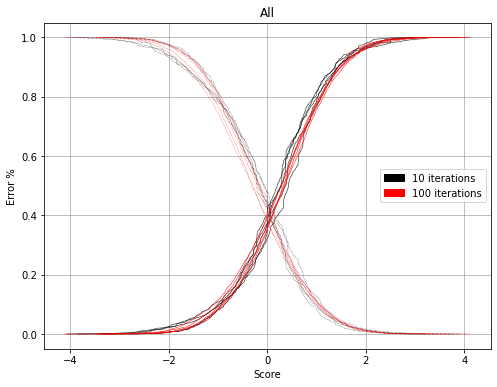

In [12]:
%%time
train_selector=np.random.rand(df.shape[0]) > 0.8
Train=D.get_subset(train_selector)
Test=D.get_subset(~train_selector)

param['num_round']=10
log10=simple_bootstrap(Train,Test,param,ensemble_size=5)
print(Train[0])
print(Test)
param['num_round']=100
log100=simple_bootstrap(Train,Test,param,ensemble_size=5)
print(log10)

# param['num_round']=10
# log10=simple_bootstrap(Train,Test,param,ensemble_size=30)
# param['num_round']=100
# log100=simple_bootstrap(Train,Test,param,ensemble_size=30)

styled_logs=[
    {   'log':log10,
        'style':['k:','k-'],
        'label':'10 iterations',
        'label_color':'k'
    },
    {   'log':log100,
        'style':['r:','r-'],
        'label':'100 iterations',
        'label_color':'r'
    }
]
_mean,_std=plot_scores(styled_logs,title='All')

pickle_file=f'data/DumpNoSplit.pk'
Dump={'styled_logs':styled_logs,
     'tree':tree,
     'mean':_mean,
     'std':_std}
pkl.dump(Dump,open(pickle_file,'wb'))
!ls -l $pickle_file

## Train on Urban only
Random split into train and test.

[[-14.03507901  -2.03335127 -13.34743269 ...   0.           0.
    0.        ]
 [ -0.9059534    2.802495     3.55650397 ...   0.           0.
    1.        ]
 [ -1.96670386   2.09990053   2.84901097 ...   0.           0.
    1.        ]
 ...
 [-11.25194322  -0.28819824   0.23228479 ...   0.           0.
    1.        ]
 [ -5.40789177  -3.42327911  -3.31638668 ...   0.           0.
    0.        ]
 [  0.12115776  -0.99445942  -1.16636911 ...   0.           0.
    1.        ]]
[{'i': 0, 'bst': <xgboost.core.Booster object at 0x7fe27417d3c8>, 'y_pred': array([-0.0180567 ,  0.4720511 ,  0.4396905 , ..., -0.45202547,
       -2.204361  , -0.8507498 ], dtype=float32), 'y_test': array([0, 1, 1, ..., 1, 1, 1], dtype=int8)}, {'i': 1, 'bst': <xgboost.core.Booster object at 0x7fe27b4b6780>, 'y_pred': array([ 0.4309965 ,  0.1199635 ,  0.4309965 , ..., -1.6015835 ,
       -1.0586697 ,  0.68157226], dtype=float32), 'y_test': array([0, 1, 1, ..., 1, 1, 1], dtype=int8)}, {'i': 2, 'bst': <xgboost.core.B

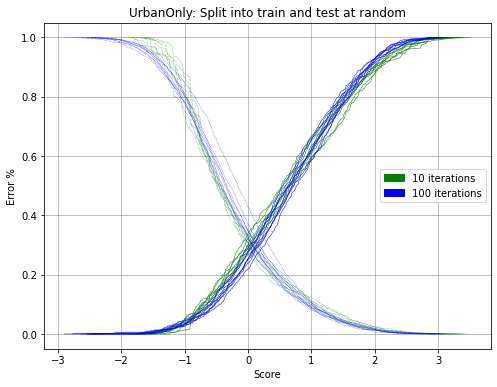

In [13]:
%%time
urban=True
area= 'Urban' if urban else 'Rural'
selector=df['urban']==urban
subData=D.get_subset(selector)
subD=DataSplitter(subData)

train_selector=np.random.rand(subData.shape[0]) > 0.7
print(subData)
Train=subD.get_subset(train_selector)
Test=subD.get_subset(~train_selector)

# param['num_round']=10
# log10=simple_bootstrap(Train,Test,param,ensemble_size=30)
# param['num_round']=100
# log100=simple_bootstrap(Train,Test,param,ensemble_size=30)
param['gamma']=0.5
param['eta']=0.3
param['num_round']=10
log10=simple_bootstrap(Train,Test,param,ensemble_size=8)
param['num_round']=100
log100=simple_bootstrap(Train,Test,param,ensemble_size=8)
print(log10)
styled_logs=[
    {   'log':log10,
        'style':['g:','g-'],
        'label':'10 iterations',
        'label_color':'g'
    },
    {   'log':log100,
        'style':['b:','b-'],
        'label':'100 iterations',
        'label_color':'b'
    }
]

_mean,_std=plot_scores(styled_logs,title=f'{area}Only: Split into train and test at random')

pickle_file=f'data/Dump{area}.pk'
Dump={'styled_logs':styled_logs,
     'tree':tree,
     'mean':_mean,
     'std':_std}
pkl.dump(Dump,open(pickle_file,'wb'))
!ls -l $pickle_file

## Train on Rural only
Random split into train and test.

accuracy_1 0.6638123603871928
accuracy_0 0.6638123603871928
accuracy_1 0.6224869694713329
accuracy_0 0.6224869694713329
accuracy_1 0.6824274013402829
accuracy_0 0.6824274013402829
accuracy_1 0.637379002233805
accuracy_0 0.637379002233805
accuracy_1 0.6626954579300074
accuracy_0 0.6626954579300074
accuracy_1 0.6757259865971705
accuracy_0 0.6757259865971705
accuracy_1 0.6801935964259122
accuracy_0 0.6801935964259122
accuracy_1 0.7107222635889799
accuracy_0 0.7107222635889799
accuracy_1 0.6641846612062546
accuracy_0 0.6641846612062546
accuracy_1 0.6887565152643336
accuracy_0 0.6887565152643336
accuracy_1 0.7125837676842889
accuracy_0 0.7125837676842889
accuracy_1 0.6701414743112435
accuracy_0 0.6701414743112435
accuracy_1 0.6827997021593447
accuracy_0 0.6827997021593447
accuracy_1 0.6857781087118392
accuracy_0 0.6857781087118392
accuracy_1 0.731198808637379
accuracy_0 0.731198808637379
accuracy_1 0.7058823529411765
accuracy_0 0.7058823529411765
-rw-r--r-- 1 t8zhou root 8422869 Jun  2 22:3

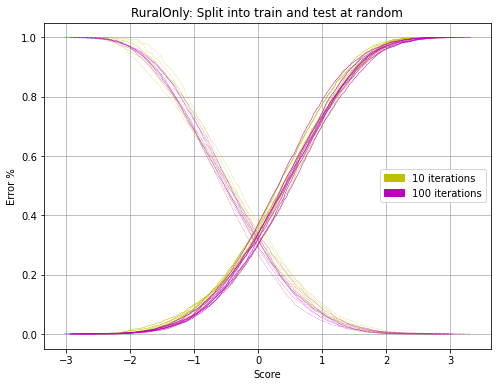

In [14]:
urban=False
area= 'Urban' if urban else 'Rural'
selector=df['urban']==urban
subData=D.get_subset(selector)
subD=DataSplitter(subData)

train_selector=np.random.rand(subData.shape[0]) > 0.8
Train=subD.get_subset(train_selector)
Test=subD.get_subset(~train_selector)

param['gamma']=0.5
param['eta']=0.3
param['subsample']=0.9
param['max_depth']=5
# param['num_round']=10
# log10=simple_bootstrap(Train,Test,param,ensemble_size=30)
# param['num_round']=100
# log100=simple_bootstrap(Train,Test,param,ensemble_size=30)
param['num_round']=10
log10=simple_bootstrap(Train,Test,param,ensemble_size=8)
param['num_round']=500
log100=simple_bootstrap(Train,Test,param,ensemble_size=8)

styled_logs=[
    {   'log':log10,
        'style':['y:','y-'],
        'label':'10 iterations',
        'label_color':'y'
    },
    {   'log':log100,
        'style':['m:','m-'],
        'label':'100 iterations',
        'label_color':'m'
    }
]

_mean,_std=plot_scores(styled_logs,title=f'{area}Only: Split into train and test at random')

pickle_file=f'data/Dump{area}.pk'
Dump={'styled_logs':styled_logs,
     'tree':tree,
     'mean':_mean,
     'std':_std}
pkl.dump(Dump,open(pickle_file,'wb'))
!ls -l $pickle_file